In [1]:
# Hyperparameters:
# RGC: g_pas (actually Anna said I shouldn't chnage anything for RGC so maybe confirm)
# Synapse: GMAX, GMAXN
# BC: gcabar_Bip_CaL

In [2]:
from neuron import h
import os
import numpy as np
import matplotlib.pyplot as plt
from plots import plot_cell, plot_cell_with_electrode, plot_bc_rgc
from BC_model_template import ONBipolarCell

--No graphics will be displayed.


## -----------------------------------------------------------
## PART 1 — Loading mechanisms and initializing model
## -----------------------------------------------------------

In [3]:
# Load compiled channel mechanisms and standard run system
h.nrn_load_dll("/Users/lillikiessling/Documents/Stanford/Code/BC_model/Ion_channels/arm64/libnrnmech.dylib")
h.load_file('stdrun.hoc') 
#h.load_file("nrn/cells/gc.nrn")            # defines soma, dend1[], dend2[], dend3[], dend4[], dend5[], dend6[]
h.load_file("RGC_model_Anna/RGC_20171004_S1W3C3_ON_S_200um_dend_low_14um_diameter_3um_axon_up_6um_axon_sections_20_axon_points_3000_axon_diam_1um.hoc")  # defines soma, dend[], axon[]
h.load_file("nrn/cells/BC_Euler9_ON.hoc")

1.0

In [4]:
# Global synaptic parameters 
NumSites = 10      # number of release sites per ribbon (from mod file)
GMAX  = 0.00256    # AMPA/NMDA maximal conductance (default in model)
GMAXN = 0.00011    # secondary NMDA-related conductance
ABSR  = 0.0        # Absolute refractory period (turned off)

GMAX = GMAX * 1.7
GMAXN = GMAXN * 1.7

## -----------------------------------------------------------
## PART 2 — Construct RGC cell
## -----------------------------------------------------------

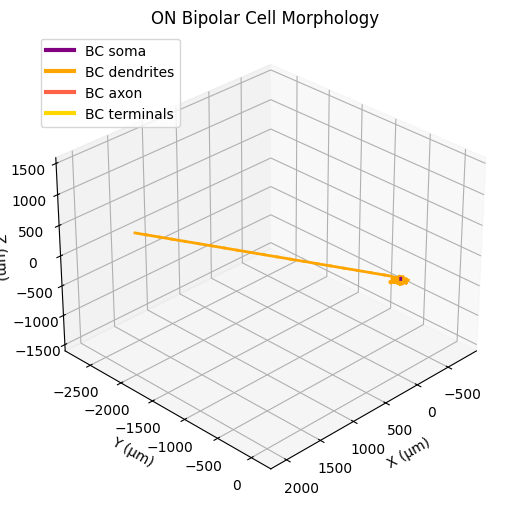

In [5]:
rgc_cell = h.RGC_20171004_S1W3C3_ON_S_200um_dend_low_14um_diameter_3um_axon_up_6um_axon_sections_20_axon_points_3000_axon_diam_1um()
plot_cell(rgc_cell)
for sec in rgc_cell.all:
    sec.g_pas = 1/70000.0

In [6]:
# print("=== DENDRITE TOPOLOGY MAP (AUTO-DETECT) ===")

# # 1. Collect all dendrite sections dynamically
# dlist = []
# dindices = []

# for sec in h.allsec():
#     name = sec.name()
#     if ".dend[" in name:
#         idx = int(name.split("dend[")[1].split("]")[0])
#         dlist.append(sec)
#         dindices.append(idx)

# # sort lists by index
# dlist = [sec for _, sec in sorted(zip(dindices, dlist), key=lambda x: x[0])]
# dindices = sorted(dindices)

# N = len(dlist)
# print(f"Found {N} dendrites (0..{N-1})")

# # helper: clean name
# def secname(sec):
#     return sec.name().split('.')[-1]

# # containers
# parent = {i: None for i in range(N)}
# children = {i: [] for i in range(N)}
# depth = {i: None for i in range(N)}

# # 2. Determine parents using SectionRef
# for i, sec in enumerate(dlist):
#     sr = h.SectionRef(sec=sec)
#     if sr.has_parent():
#         parent[i] = secname(sr.parent)
#     else:
#         parent[i] = None

# # 3. Convert parent names → parent index
# parent_idx = {}
# for i, pname in parent.items():
#     if pname is None:
#         parent_idx[i] = None
#         continue
#     if pname == "soma":
#         parent_idx[i] = "soma"
#         continue
#     found = None
#     for j, sec in enumerate(dlist):
#         if secname(sec) == pname:
#             found = j
#             break
#     parent_idx[i] = found

# # 4. Build children list
# for child, pindex in parent_idx.items():
#     if isinstance(pindex, int):
#         children[pindex].append(child)

# # 5. Depth assign
# def assign_depth(i, d):
#     depth[i] = d
#     for c in children[i]:
#         assign_depth(c, d+1)

# # Roots are dendrites whose parent is soma
# roots = [i for i, p in parent_idx.items() if p == "soma"]

# for r in roots:
#     assign_depth(r, 0)

# # 6. Print results
# for i in range(N):
#     print(f"dend[{i:2d}] parent={parent_idx[i]} depth={depth[i]} children={children[i]}")

# print("=== END ===")


## -----------------------------------------------------------
## PART 3 — Construct Bipolar Cell Terminal
## -----------------------------------------------------------

In [7]:
bc_cell = ONBipolarCell()
# Choose one Terminal for voltage clamp
term_list = list(bc_cell.terminal)
preSyn = term_list[0]

for sec in bc_cell.all:
    sec.cao = 1.8 #mM
    sec.cai = 0.0001 #mM

preSyn.gcabar_Bip_CaL = 5 # TODO: verify hyperparameter

bpclamp = h.VClamp(preSyn(0.5))
bpclamp.dur[0] = 5500

In [8]:
# Load the bipolar command waveform
vec = h.Vector()
f = h.File()

if not f.ropen("bp_Sikora.dat"):
    h('printf("WARNING: cannot open bp_Sikora.dat; clamp waveform = 0.\\n")')
    vec = h.Vector(0)
else:
    vec.scanf(f, 192000, 1, 1)
    f.close()

vec.play(bpclamp._ref_amp[0], 0.025)

Vector[0]

## -----------------------------------------------------------
## PART 4 — Construct Ribbon Synapses
## -----------------------------------------------------------


In [9]:
# Helper: create a ribbon synapse at midpoint of a section
def make_syn_at(sec, idx):
    """Create a ribbon_tiger at sec(0.5) with Ca pointers hooked up."""
    syn = h.ribbon_tiger_simple(sec(0.5))
    h.setpointer(preSyn(0.5).ca_ion._ref_cai,  'preCA', syn)
    return syn

In [10]:
#MAPPING TABLE
mapped_dend1 = [26,27,28,29,30,31,32,33,34,35,36,37,38,39]   # 14
mapped_dend2 = [62,63,64]                                   # 3
mapped_dend3 = [21]                                         # 1
mapped_dend4 = [59]                                         # 1
mapped_dend5 = [60]                                         # 1
mapped_dend6 = [0,1,2]                                      # 3

# Full list of 23 synaptic *locations*
syn_locs = (
    mapped_dend1 +
    mapped_dend2 +
    mapped_dend3 +
    mapped_dend4 +
    mapped_dend5 +
    mapped_dend6
)

assert len(syn_locs) == 23

# Allocate arrays
synapse  = [None]*23
synapse2 = [None]*23
synapse3 = [None]*23

# Create synapses for all 23 locations × 3 ribbons
for idx, dend_idx in enumerate(syn_locs):
    sec = rgc_cell.dend[dend_idx]
    synapse[idx]  = make_syn_at(sec, idx)
    synapse2[idx] = make_syn_at(sec, idx)
    synapse3[idx] = make_syn_at(sec, idx)

print("Created 69 ribbon synapses ")

Created 69 ribbon synapses 


In [11]:
# Apply global synaptic parameters to every synapse
def set_stim():
    for arr in (synapse, synapse2, synapse3):
        for s in arr:
            if s is None:
                continue
            s.gmax       = GMAX
            s.gmaxN      = GMAXN
            s.AbsRefract = ABSR
            s.mg         = 0.5

set_stim()

## ---------------------------------------------------
## Part 5 - Recording Vectors + Simulation Execution
## ---------------------------------------------------

In [ ]:
# Recording vectors 
# Simulation time (ms)
t_vec = h.Vector().record(h._ref_t)

# Panel A: bipolar command voltage waveform
v_bipolar_cmd = h.Vector().record(bpclamp._ref_amp[0])

# Panel B: presynaptic Ca2+ at depth = 25 nm 
ca1_vec = h.Vector().record(preSyn(0.5)._ref_cai)

# Panel C: Release Rate (Orate) from all ribbon synapses
Orate_vecs = []
for arr in (synapse, synapse2, synapse3):
    for s in arr:
        v = h.Vector().record(s._ref_Orate)
        Orate_vecs.append(v)

# Panel D: Release Events (release_start[i])
# Each synapse has release_start[NumSites] -> 69 synapses × 10 sites = 690 NEURON vectors
release_event_flags = []
for arr in (synapse, synapse2, synapse3):
    for s in arr:
        for i in range(NumSites):
            v = h.Vector().record(s._ref_release_start[i])
            release_event_flags.append(v)


# Panel E: Synaptic Current (EPSC) from all ribbon synapses (sum of AMPA + NMDA from all ribbon synapses)
I_syn_vecs = []

for arr in (synapse, synapse2, synapse3):
    for s in arr:
        if s is None: 
            continue
        v = h.Vector().record(s._ref_i)
        I_syn_vecs.append(v)

# Panel F: RGC soma membrane voltage
v_soma = h.Vector().record(rgc_cell.soma(0.5)._ref_v)

In [13]:
# Run simulation
h.dt = 0.025 # ms
h.tstop = 5500
h.CVode().active(0)
h.finitialize(-65)
h.run()

0.0

In [14]:
# Postprocessing
# Convert to numpy
t    = t_vec.as_numpy()
v_cmd = v_bipolar_cmd.as_numpy()
ca1  = ca1_vec.as_numpy()
v_s  = v_soma.as_numpy()

# Compute averaged release rate (Panel C)
Orate_np = np.array([v.as_numpy() for v in Orate_vecs])
avg_rate = Orate_np.mean(axis=0) / NumSites


# Extract release event times: detect changes in release_start arrays
event_trains = []
for v in release_event_flags:
    arr = np.array(v)
    changes = np.where(np.diff(arr) != 0)[0]
    times = arr[changes + 1]
    event_trains.append(times)


# Compute EPSC (sum of synaptic currents)
I_syn_np = np.array([v.as_numpy() for v in I_syn_vecs])
EPSC = I_syn_np.sum(axis=0)      # nA
EPSC_pA = EPSC * 1000            # convert to pA

## ------------------------------------------
## Part 6 - Plotting
## ------------------------------------------

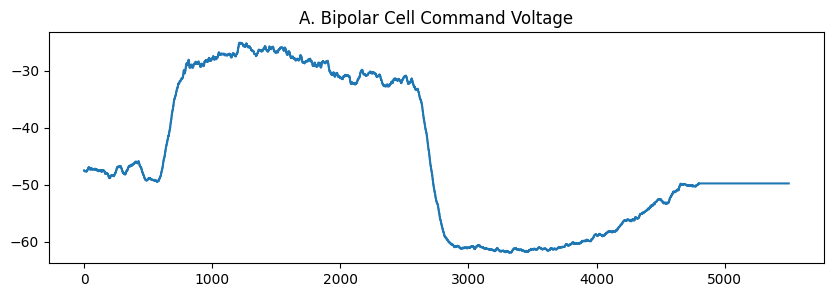

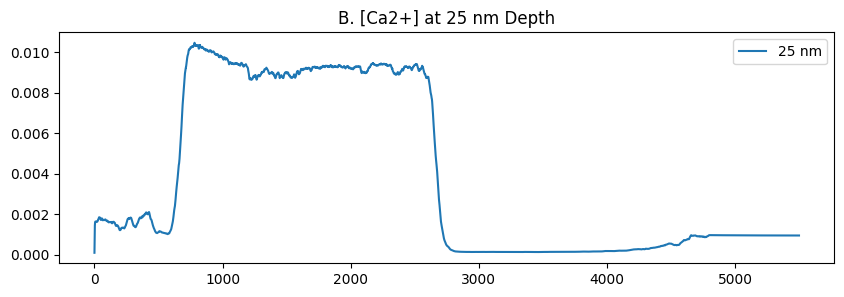

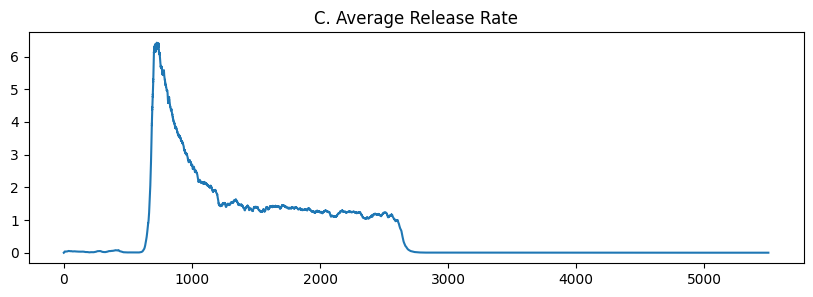

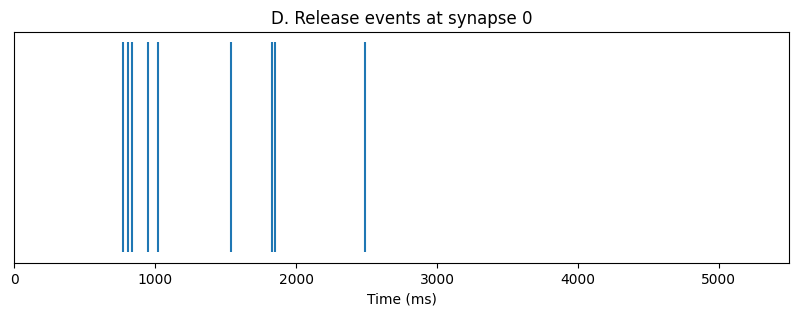

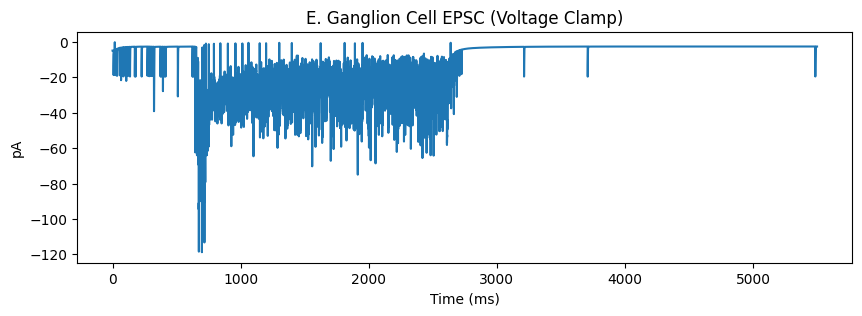

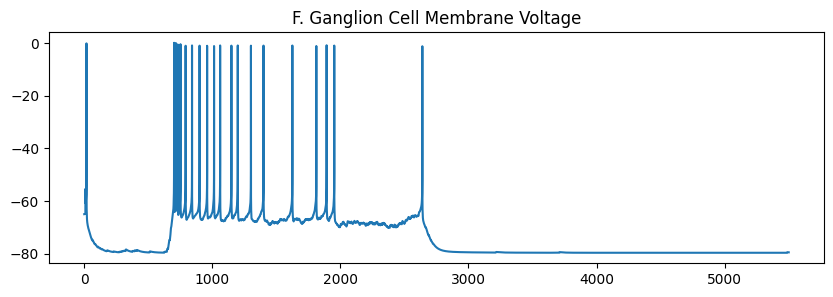

In [15]:
# A — Bipolar Cell Command Voltage
plt.figure(figsize=(10, 3))
plt.plot(t, v_cmd)
plt.title("A. Bipolar Cell Command Voltage")
plt.show()

# B — Presynaptic Ca2+ at 25 nm depth (sharp increases during depolarization)
plt.figure(figsize=(10, 3))
plt.plot(t, ca1, label="25 nm")
plt.legend()
plt.title("B. [Ca2+] at 25 nm Depth")
plt.show()


# C — Average Release Rate (Orate across 69 ribbon synapses -> smooth rate)
plt.figure(figsize=(10, 3))
plt.plot(t, avg_rate)
plt.title("C. Average Release Rate")
plt.show()

#D — Release Events (shows all vesicle release events -> raster of vertical tick marks)
k = 0
plt.figure(figsize=(10, 3))
plt.vlines(event_trains[k], 0, 1)
plt.xlim(0, len(t)*h.dt)
plt.yticks([])
plt.title(f"D. Release events at synapse {k}")
plt.xlabel("Time (ms)")
plt.show()

# E —  Ganglion Cell EPSC (Voltage Clamp) (Sum of all AMPA+NMDA synaptic currents from all 69 synapses -> inward current during release bursts)
plt.figure(figsize=(10, 3))
plt.plot(t, EPSC_pA)
plt.title("E. Ganglion Cell EPSC (Voltage Clamp)")
plt.ylabel("pA")
plt.xlabel("Time (ms)")
plt.show()

# F — Ganglion Cell Membrane Voltage (shows natural RGC spiking, NOT voltage clamp -> action potentials during strong synaptic activation)
plt.figure(figsize=(10, 3))
plt.plot(t, v_s)
plt.title("F. Ganglion Cell Membrane Voltage")
plt.show()